In [1]:
from tkinter import *
from tkinter import ttk, filedialog
from tkinter.filedialog import askopenfilename
import csv
from pathlib import Path
import pymongo
import numpy as np
# Use sentinel for missing values
from numpy import nan as NA
import pandas as pd
# For showing plots in tkinter
import matplotlib.pyplot as plt
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg,  
NavigationToolbar2Tk) 
import seaborn as sns

# connect to mongodb
client = pymongo.MongoClient("mongodb://localhost:27017")
# create db
db_formative = client["summative"]
# create collection
collection_vendors = db_formative["test-7"]

In [2]:
# Global variables
fileButtons = ["inspections", "inventory", "violations"]
fileRoutes = {fileButtons[0]:"", fileButtons[1]:"", fileButtons[2]:""}

In [3]:
class Parser(object):
    def __init__(self, collection, csvFile):
        self.collection = collection
        self.csvFile = csvFile
        self.dataList = []
        self.dataObj = {}
        self.violationsSet = {}
        # lists and a set (no duplicates in set)
        self.dataDict = {'inspections':[], 'inventory':[], 'violations':[], 'violation codes':set()}
        
    def parseData(self):
        self.readInspections()
        self.readInventory()
        self.readViolations()
        return self.dataDict
                
    def readInspections(self):
        with open(self.csvFile['inspections'], newline="", encoding='utf-8-sig') as inFile: 
            dataReader = csv.DictReader(inFile)
            for row in dataReader:
                # Do not add inactive programs
                if row['PROGRAM STATUS'] == 'INACTIVE':
                    continue
                # Add Mongo ID as Serial Number with INS- prefix
                print(row['SERIAL NUMBER'])
                row['_id'] = "INS-"+row['SERIAL NUMBER']
                # Split PE Description and create new row with seating
                try:
                    start,mid = row["PE DESCRIPTION"].split(' (')
                    mid,end = mid.split(')')
                    row["PE DESCRIPTION"] = start+end
                    row["SEATING DETAILS"] = mid
                except:
                    print('no seating desc')
                # NEW: remove second half of zip (e.g. 90001-1234 remove '1234')
                try:
                    zipStart = row["FACILITY ZIP"].split('-')
                    row["FACILITY ZIP"] = zipStart[0]
                except:
                    print('no zip')
                self.dataDict['inspections'].append(row)
#             print(f'Inspection first doc: \n{self.dataDict['inspections'][0]}')
            ins = self.collection.insert_many(self.dataDict['inspections'])
            print('=> Inspections inserted into DB')

    def readInventory(self):
         with open(self.csvFile['inventory'], newline="", encoding='utf-8-sig') as inFile: 
            dataReader = csv.DictReader(inFile)
            for row in dataReader:
                # Add Mongo ID as Facility ID with F_ID- prefix
                print(row['FACILITY ID'])
                row['_id'] = 'F_ID-'+row['FACILITY ID']
                # Split PE Description and create new row with seating
                start,mid = row["PE DESCRIPTION"].split(' (')
                mid,end = mid.split(')')
                row["PE DESCRIPTION"] = start+end
                row["SEATING DETAILS"] = mid
                self.dataDict['inventory'].append(row)
#             print(f'Inventory first doc: \n{self.dataDict['inventory'][0]}')
            ins = self.collection.insert_many(self.dataDict['inventory'])
            print('=> Inventory inserted into DB')
            
    def readViolations(self):
        with open(self.csvFile['violations'], newline="", encoding='utf-8-sig') as inFile: 
            dataReader = csv.DictReader(inFile)
            # Group the rows by serial number so they can be added to the corresponding inspection
            for row in dataReader:
                # Add violations codes to a set - no duplicates
                self.dataDict['violation codes'].add(row['VIOLATION CODE'])
                if row['SERIAL NUMBER'] in self.dataObj:
                    self.dataObj[row['SERIAL NUMBER']].append(row)
                else:
                    self.dataObj[row['SERIAL NUMBER']] = [row]
            self.dataDict['violations'].append(self.dataObj)
#             print(f'Violations first doc: \n{self.dataDict['violations'][0]}')
            ins = collection_vendors.insert_many(self.dataDict['violations'])
            print('=> Violations inserted into DB')
        
        
    def formatViolations(self):
        for violation in self.dataObj:
            collection_vendors.update_one({'_id': 'INS-'+violation}, {'$set': {'VIOLATIONS': self.dataObj[violation]}})
            

In [4]:
class ButtonUpload(object):
    def __init__(self, fileButtons, fileLabels, counter, mainframe):
        self.fileButtons = fileButtons
        self.fileLabels = fileLabels
        self.counter = counter
        self.mainframe = mainframe
        self.filePath = ''
        self.uploadLabel = StringVar()

    def browseFile(self):
        self.filePath = askopenfilename(filetypes=[("CSV files", ".csv")])
        fileName = Path(self.filePath)
        self.uploadLabel.set(fileName.name)
        print(self.filePath)
        self.setFileRoutes()
    
    def setFileRoutes(self):
        fileRoutes[self.fileButtons] = self.filePath
        print(fileRoutes)
        
    def createButton(self):
        ttk.Label(self.mainframe, text=f"Upload data: {self.fileButtons}", anchor="w").grid(row=self.counter+1, column=0, sticky="w")
        Button(self.mainframe, text="Upload file", command=self.browseFile).grid(row=self.counter+1, column=1, sticky="w")
        ttk.Label(self.mainframe, textvariable=self.uploadLabel).grid(row=self.counter+1, column=2, sticky="w")  

In [5]:
class AveragesCalculator(object):
    def __init__(self, year, category):
        self.year = year
        self.category = category
        
    def zipScores(self):
        print(f'Calculating stats for: \n- Year = {self.year} \n- Category = {self.category}')
        # Find inspection documents - look in ispections (INS-) with year
        resultsInspections = collection_vendors.find({'_id':{'$regex':'INS-'},'ACTIVITY DATE':{'$regex':self.year}})

        # Create dict of facility zips with lists of their scores
        zipScoresDict = {}  
        for r in resultsInspections:
            key = str(r[self.category])
            if(r['SCORE'] == ''):
                value = NA
            else:
                value = int(r['SCORE'])
            if key in zipScoresDict:
                zipScoresDict[r[self.category]].append(value)
            else:
                zipScoresDict[key] = [value]
        return self.calcZipStats(zipScoresDict)


    def calcZipStats(self, zipScoresDict):
        zipScoresMean = {}
        zipScoresMean = {self.category:[],'mean':[],'median':[],'mode':[]}
        for x in zipScoresDict:
            # Create Series to calc mean, mode, median
            tempSeries = pd.Series(zipScoresDict[x])
            mean = tempSeries.mean()
            mode = tempSeries.mode().tolist()
            median = tempSeries.median()

            # mean, mode, median as columns
            zipScoresMean[self.category].append(x)
            zipScoresMean['mean'].append(mean)
            zipScoresMean['median'].append(median)
            zipScoresMean['mode'].append(mode)

        # Create DataFrame
        zipScoresDF = pd.DataFrame(zipScoresMean)
        # sort by ascending cat - easier to find for user (esp. zip)
        zipScoresDF.sort_values(by=[self.category],inplace=True)
        # set cat as index
        zipScores_noIndex = zipScoresDF.set_index(self.category)
        
        return zipScores_noIndex
 

In [6]:
class UserInterface(object):
    def __init__(self, title):
        self.title = title
        self.mainframe = None
        self.window = Tk()
        self.window.title(self.title)
        self.window.geometry("600x400")
        self.window.columnconfigure(0, weight=1)
        self.window.rowconfigure(0, weight=1)
        self.calcCategory = StringVar()
        self.calcYear = StringVar()
        self.violationsDict = None
        self.dataDict = None
        
    def createWindow(self):
        self.createInitialFrame()
        self.window.mainloop()
        
    def createInitialFrame(self):
         # variables
        labelTextOne = StringVar()
        labelTextTwo = StringVar()
        labelTextThree = StringVar()
        fileLabels = [labelTextOne, labelTextTwo, labelTextThree]
        # Config layout
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        self.mainframe.grid_rowconfigure(4, weight=1)
        self.mainframe.grid_columnconfigure(2, weight=1)
        heading = ttk.Label(self.mainframe, text="Load your dataset", anchor="w").grid(row=0, sticky="nw")
        # Create buttons for file uploads
        for i in range(0, len(fileButtons)): 
            newButton = ButtonUpload(fileButtons[i], fileLabels[i], i, self.mainframe)
            newButton.createButton()
        # Buttons for Cancel and Clean & Save
        footer = ttk.Frame(self.window, padding="16 0 0 0").grid(row=5, column=1)
        cancelButton = Button(self.mainframe, text="Cancel & exit", bg="red").grid(row=4, column=0, sticky="sw")
        saveButton = Button(self.mainframe, text="Save", command=self.handleSave).grid(row=4, column=2,sticky="se")
        
    def handleSave(self):
        self.loadingFrame('Your data is being parsed and loaded into MongoDB...')
        parser = Parser(collection_vendors, fileRoutes)
        self.dataDict = parser.parseData()
        parser.formatViolations()
        self.createNotebook()
    
    def loadingFrame(self, text):
        self.mainframe.destroy()
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        heading = ttk.Label(self.mainframe, text="Please wait:", anchor="w").grid(row=0, sticky="nw")
        subheading = ttk.Label(self.mainframe, text=text, anchor="w").grid(row=1, sticky="nw")
        
    def createNotebook(self):
        print('here')
        self.mainframe.destroy()
        self.mainframe = ttk.Notebook(self.window)
        f1 = ttk.Frame(self.mainframe)  
        f2 = ttk.Frame(self.mainframe)  
        f3 = ttk.Frame(self.mainframe) 
        self.mainframe.add(f1, text='Averages')
        self.mainframe.add(f2, text='Violations per Establishment')
        self.mainframe.add(f3, text='Correlations')
        # ====== Widget for tab 1
        heading_one = ttk.Label(f1, text="Mean, Mode and Median", anchor="w").grid(row=0, sticky="nw")
        # Radio - Type
        radioHeadingOne = ttk.Label(f1, text="Calculate by seating type or zip codes:", anchor="w").grid(row=0, sticky="nw")
        Radiobutton(f1, text="Vendor seating type", padx = 20, variable=self.calcCategory, value='SEATING DETAILS').grid(row=1, column=0, sticky='w')
        Radiobutton(f1, text="Zip Code", padx = 20, variable=self.calcCategory, value='FACILITY ZIP').grid(row=2, column=0, sticky='w')
        # Radio - Years
        radioHeadingTwo = ttk.Label(f1, text="Select Year", anchor="w").grid(row=3, sticky="nw")
        yearsArr = ['2016', '2017', '2018', '2019']
        for i in range(len(yearsArr)):
            Radiobutton(f1, text=yearsArr[i], padx = 20, variable=self.calcYear, value=yearsArr[i]).grid(row=i+4, column=0, sticky='w')
        # Calc button
        calcButton = Button(f1, text="Calculate", command=self.calcAverages).grid(row=8, column=0, sticky="sw")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        
        # ====== Widget for tab 2
        heading_two = ttk.Label(f2, text="Violations per Establishment", anchor="w").grid(row=0, sticky="nw")
        self.createViolationsPlot(f2)
        
        # ====== Widget for tab 3
        heading_two = ttk.Label(f3, text="Correlation between the number of violations commited per vendor and their zip code", anchor="w").grid(row=0, sticky="nw")
        self.createCorrelationsPlot(f3)
        
    def createViolationsPlot(self, f2):
        # Create dict with violation codes as keys and no. of facilities that commited that violation as values
        vioDict = {}
        # Sort the violation codes for easier reading for user
        sortedCodes = sorted(self.dataDict['violation codes'])
        for v in sortedCodes:
            resultsInspections = collection_vendors.find({'VIOLATIONS.VIOLATION CODE':v}, {'FACILITY NAME':1})
            # Hash map to see if facility has been included - only need ONE instance of violation per facility
            facilityNames = {}
            for r in resultsInspections:
                # if facility name has already been counted, continue to next loop
                if r['FACILITY NAME'] in facilityNames:
                    continue
                # else, facility name has not yet been counted, add appropriately
                else:
                    if v in vioDict:
                        vioDict[v] = vioDict[v] + 1
                    else:
                        vioDict[v] = 1

        
        # Display violations vs no. of establishments
        vioKeys = list(vioDict.keys())
        vioVals = list(vioDict.values())
        # Create 4 subplots using slices of the keys & values lists
        fig,a =  plt.subplots(2,2)
        a[0][0].bar(vioKeys[:round(len(vioKeys)*0.25)], vioVals[:round(len(vioKeys)*0.25)])
        a[0][1].bar(vioKeys[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)], vioVals[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)])
        a[1][0].bar(vioKeys[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)], vioVals[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)])
        a[1][1].bar(vioKeys[round(len(vioKeys)*0.75):], vioVals[round(len(vioKeys)*0.75):])
        # Show in console as well as window
        plt.show()

        # creating the Tkinter canvas containing the Matplotlib figure 
        canvas = FigureCanvasTkAgg(fig, master = f2)   
        canvas.draw() 

        # grid the canvas on the Tkinter window 
        canvas.get_tk_widget().grid(row=0) 
        
    def createCorrelationsPlot(self, f3):
        # Find number of violations per vendor, and their zip code
        insViosDict = {'Facility ID': [], 'Violations quant': [], 'Zip': []}
        insVios = collection_vendors.find({'_id':{'$regex':'INS-'}}, {'FACILITY ID':1,'VIOLATIONS':1, 'FACILITY ZIP':1})
        # Create arrays for each key in dictionary (use sentinel NA if value does not exist)
        for r in insVios:
            if 'FACILITY ID' in r:
                insViosDict['Facility ID'].append(r['FACILITY ID'])
            else:
                insViosDict['Facility ID'].append(NA)
            if 'VIOLATIONS' in r:
                insViosDict['Violations quant'].append(len(r['VIOLATIONS']))
            else:
                insViosDict['Violations quant'].append(NA)
            if 'FACILITY ZIP' in r:
                insViosDict['Zip'].append(r['FACILITY ZIP'])
            else:
                insViosDict['Zip'].append(NA)
                
        #  Create DataFrame - sorted by zip to make visualisations easier to understand
        insViosDF = pd.DataFrame(insViosDict)
        insViosDF.sort_values(by=['Zip'],inplace=True)

        # Creating the figure and Seaborn plot
        figure = Figure(figsize=(6, 6))
        ax = figure.subplots()
        sns.scatterplot(x="Zip", y="Violations quant", data=insViosDF, ax=ax)
        
        # create the Tkinter canvas 
        canvas = FigureCanvasTkAgg(figure, master = f3)   
        canvas.draw() 

        # placing the canvas on the Tkinter window 
        canvas.get_tk_widget().grid(row=1) 
    
    def calcAverages(self):
        calcCatVal = self.calcCategory.get()
        calcYearVal = self.calcYear.get()
        calcAv = AveragesCalculator(calcYearVal, calcCatVal)
        avResults = calcAv.zipScores()
        self.averagesResultsFrame(avResults, calcYearVal, calcCatVal)
        
    def averagesResultsFrame(self, resultsAv, calcYearVal, calcCatVal):
        avResultsWindow = Tk()
        avResultsWindow.title(f'Averages Results for {calcCatVal} in {calcYearVal}')
        avResultsWindow.geometry("600x400")
        avResultsWindow.columnconfigure(0, weight=1)
        avResultsWindow.rowconfigure(0, weight=1)
        mainframe = ttk.Frame(avResultsWindow, padding="16 16 16 16")
        mainframe.place(relheight=1, relwidth=1)

        tree = ttk.Treeview(mainframe)
        tree.place(relheight=1, relwidth=1)
        treescrolly = Scrollbar(mainframe, orient='vertical', command=tree.yview)
        treescrollx = Scrollbar(mainframe, orient='horizontal', command=tree.xview)
        tree.configure(xscrollcommand=treescrollx.set, yscrollcommand=treescrolly.set)
        treescrolly.pack(side='right', fill='y')
        treescrollx.pack(side='bottom', fill='x')

        tree["columns"]=("one","two","three")
        tree.column("#0", width=75, minwidth=75)
        tree.column("one", width=75, minwidth=75)
        tree.column("two", width=75, minwidth=75)
        tree.column("three", width=75, minwidth=75)

        tree.heading("#0",text="Seating")
        tree.heading("one", text="Mean")
        tree.heading("two", text="Median")
        tree.heading("three", text="Mode")

        for index, row in resultsAv.iterrows(): 
            tree.insert('','end', text=index, values=[row['mean'],row['median'],row['mode']])
        print(f'This is resultsAv: \n{resultsAv}')
 

/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '', 'violations': ''}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory_sm.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory_sm.csv', 'violations': ''}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/violations_md.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_d

here


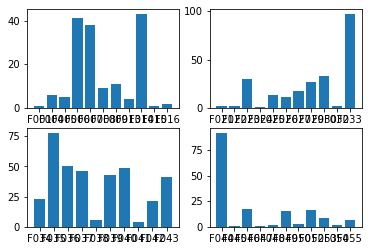

Calculating stats for: 
- Year = 2017 
- Category = SEATING DETAILS
This is resultsAv: 
                      mean  median              mode
SEATING DETAILS                                     
0-30             93.682353    94.0            [90.0]
1-1,999 SF       95.966667    96.5            [99.0]
151 +            94.833333    95.0  [93, 95, 97, 98]
2,000+ SF        94.230769    96.0            [99.0]
31-60            93.619718    94.0            [90.0]
61-150           92.890909    93.0            [90.0]
Calculating stats for: 
- Year = 2017 
- Category = FACILITY ZIP
This is resultsAv: 
              mean  median              mode
FACILITY ZIP                                
90002          NaN     NaN                []
90003         94.0    94.0              [94]
90004         93.5    93.5          [91, 96]
90005         94.5    94.5          [94, 95]
90006         92.0    92.0  [90, 91, 93, 94]
...            ...     ...               ...
93535         90.0    90.0              [90

In [7]:
ui = UserInterface('summative')
ui.createWindow()